In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | RANDOM FOREST

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support



pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical Data

In [4]:
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

# Removing noise on heating scheme | the removed coluns are shots from 1996
DB5 = DB5[~DB5["AUXHEAT"].isin(["UNKNOWN"])]

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)

DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

## Treatment to Numerical Data

In [5]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"
                         ] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI"]
 # corrections on power loss | NBI Power lost by unconfined orbits
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
# e-density in SOL | total due to NBI| total due to ICRH
fast_particles = ["NESOL","WFFORM","WFICFORM"] 
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

interesting_features = set(plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power  + fast_particles)


num_features = DB5[list(interesting_features)].select_dtypes(include=['int', 'float']).columns.tolist()

This is what I had before to join comlumns.

```Python
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[num_features] ), columns = num_features)
data = pd.concat([DB5_,DB5[categorical]], axis=1, join="inner")
```

In [6]:
data = DB5.copy()
data = data[num_features + categorical + ["label","TOK"]]

def impute_with_median(series):
    return series.fillna(series.median())

for tokamak in data["TOK"].unique():
    indx_tok = data[data['TOK'] == tokamak].index
    data.loc[indx_tok, num_features] = data[num_features].apply(impute_with_median)

data[num_features] = StandardScaler().fit_transform(data[num_features])

encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[categorical])
ohe_df = pd.DataFrame(transformed.toarray(),
                     columns=encoder.get_feature_names_out(categorical)
                     )
data_ = pd.concat([data[num_features + ["label"]], ohe_df], axis=1)

In [7]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [8]:
# Define random forest classifier with preprocessor as a pipeline

rf = RandomForestClassifier(min_samples_split=2,
                            min_samples_leaf=4,
                            n_estimators = 110,
                            max_depth = 25,
                            criterion='entropy',
                            max_features=None
                           )

rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

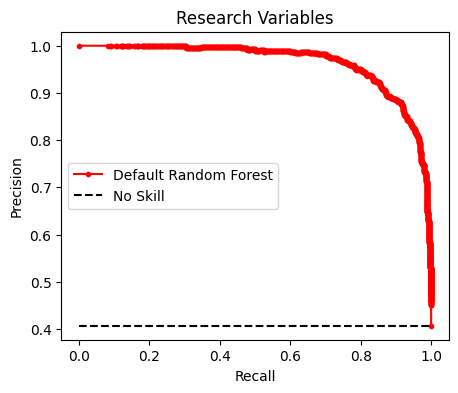

In [9]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [10]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.89319092, 0.91651865]),
 array([0.8768021 , 0.92805755]),
 array([0.88492063, 0.92225201]),
 array([ 763, 1112]))

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [11]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

               feature  importance
0               WFFORM    0.126919
1                QCYL5    0.091673
2                 ENBI    0.068703
3                 POHM    0.068008
4            WALMAT_SS    0.065045
..                 ...         ...
107            EVAP_TI    0.000000
108  ICSCHEME_HE3MIN-T    0.000000
109        DIVNAME_ILW    0.000000
110         AUXHEAT_EC    0.000000
111         CONFIG_DND    0.000000

[112 rows x 2 columns]


In [12]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['WFFORM', 'QCYL5', 'ENBI', 'POHM', 'WALMAT_SS', 'WMHD', 'PRAD',
       'LHTIME', 'PELLET_GAS-FUEL', 'ZEFF', 'PFLOSS', 'PLTH', 'EVAP_NONE',
       'NESOL', 'ZEFFNEO', 'BEIMHD', 'DWDIA', 'HYBRID_YES',
       'HYBRID_UNKNOWN', 'TORQ', 'WFICFORM', 'WALMAT_C', 'PICRH', 'PECRH',
       'CONFIG_SN', 'LIMMAT_C', 'ELMFREQ', 'LIMMAT_W', 'ELMTYPE_TYPE-I',
       'DIVMAT_W', 'PELLET_NONE', 'HYBRID_NO', 'DIVNAME_DV-II',
       'ELMTYPE_TYPE-II', 'DIVNAME_OPEN', 'WALMAT_IN/C', 'DIVNAME_MARK',
       'DIVNAME_RIB', 'DIVNAME_RDP', 'PELLET_H', 'WALMAT_IN', 'PELLET_D',
       'DIVNAME_MARKSR', 'PREMAG_YES', 'ELMTYPE_TYPE-III',
       'HYBRID_HYBRID', 'DIVMAT_C', 'DIVNAME_DV-III', 'WALMAT_C-W',
       'ICSCHEME_HMIN', 'ICSCHEME_NONE', 'DIVNAME_PLATES1',
       'DIVNAME_UNKNOWN', 'AUXHEAT_NB', 'ECHMODE_UNKNOWN',
       'PREMAG_UNKNOWN', 'EVAP_BO', 'ELMTYPE_UNKNOWN', 'DIVMAT_C-W',
       'WALMAT_W', 'PREMAG_NO', 'CONFIG_SN(L)', 'EVAP_BE', 'CONFIG_DN',
       'DIVNAME_MARKIAP', 'LIMMAT_C-W', 'AUXHEAT

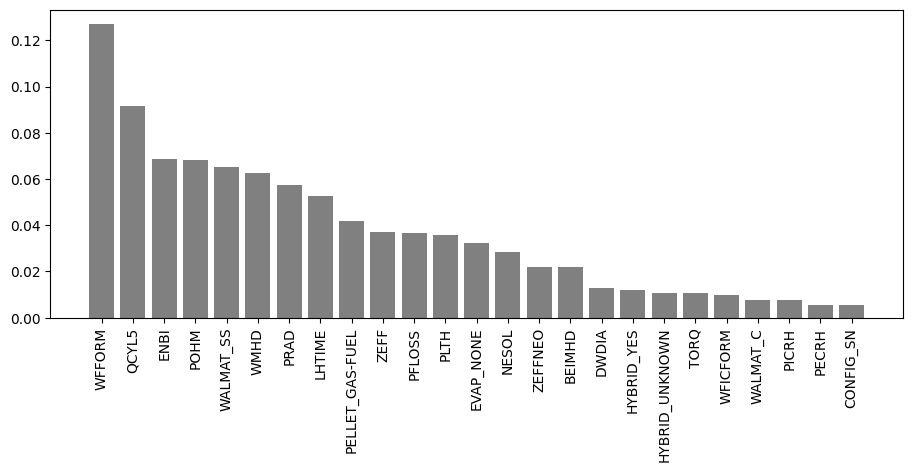

In [13]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [14]:
# Quite Important
df[df.importance > 1e-3]

,feature,importance
0,WFFORM,0.126919
1,QCYL5,0.091673
2,ENBI,0.068703
3,POHM,0.068008
4,WALMAT_SS,0.065045
5,WMHD,0.062386
6,PRAD,0.057283
7,LHTIME,0.052586
8,PELLET_GAS-FUEL,0.041835
9,ZEFF,0.037026


In [15]:
# Not so important
df[df.importance < 1e-3]

,feature,importance
51,DIVNAME_PLATES1,0.000933
52,DIVNAME_UNKNOWN,0.000860
53,AUXHEAT_NB,0.000819
54,ECHMODE_UNKNOWN,0.000806
55,PREMAG_UNKNOWN,0.000747
...,...,...
107,EVAP_TI,0.000000
108,ICSCHEME_HE3MIN-T,0.000000
109,DIVNAME_ILW,0.000000
110,AUXHEAT_EC,0.000000


In [16]:
df[df.importance == 0]

,feature,importance
88,CONFIG_BOT,0.0
89,EVAP_DECABOA,0.0
90,LIMMAT_NONE,0.0
91,LIMMAT_MO,0.0
92,CONFIG_LIM,0.0
93,CONFIG_MAR,0.0
94,EVAP_UNKNOWN,0.0
95,DIVMAT_TI12,0.0
96,DIVMAT_NONE,0.0
97,CONFIG_IW,0.0


In [17]:
data["CONFIG"].unique()

array(['DN', 'SN', 'SN(L)', 'SN(U)', 'MAR', 'TOP', 'BOT', 'IW', 'DND',
       'LIM'], dtype=object)